# Drinking Task Pipeline


Diese Pipeline führt eine Klassifikation von Trinkbewegungen durch.

Die Elemente, welche angepasst werden können, um Ansätze auszuprobieren, wurden mit ✏️ gekennzeichnet.

#### Geeignete Parameter (Beispiel):

**3.2 Ansatz auswählen**
- Ansatz 1: Absolute Datenpunkte mit geschnittenen Videos
- n_frames: **38**
    
**4.3 Modell anwenden**
- n_neurons: **64**
- RNN-Modell

# 1. Import Dependecies

In [162]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import RandomizedSearchCV

import math

# 2. Landmarks extrahieren

In [163]:
def extract_landmarks_normal():
    %run extract_landmarks.py --video-dir data/video/normal --output-file data/landmarks_normal.csv

In [164]:
def extract_landmarks_compensation():
    %run extract_landmarks.py --video-dir data/video/compensation --output-file data/landmarks_compensation.csv

In [165]:
# Falls die Landmarks neu extrahiert werden sollen, folgende Befehle auskommentieren: ✏️
# extract_landmarks_normal()
# extract_landmarks_compensation()

# 3. Data Pre-Processing

In [166]:
# Landmarks einlesen
data_normal = pd.read_csv('data/landmarks_normal.csv')
data_compensation = pd.read_csv('data/landmarks_compensation.csv')

# Label setzen (Kompensation = 1, keine Kompensation = 0)
data_compensation.compensation = 1
data_normal.compensation = 0
# Normal- und Kompensation-Liste zusammenführen
data = pd.concat([data_normal, data_compensation], axis=0)
data[data.frame == 1]

,path,frame,compensation,x_0,y_0,z_0,x_1,y_1,z_1,x_2,...,z_29,x_30,y_30,z_30,x_31,y_31,z_31,x_32,y_32,z_32
0,data/video/normal\01_trinken.mp4,1,0,1000.68180,327.32000,-487.17905,1015.6097,300.61502,-435.28815,1024.7533,...,-224.031780,886.21216,1200.91050,-312.124760,1013.16100,1197.84010,-452.02050,807.56680,1270.23230,-595.89825
177,data/video/normal\02_trinken.mp4,1,0,1035.52190,347.54290,-436.01190,1050.1111,318.36487,-385.82090,1059.7306,...,-258.592000,1032.71440,1069.01430,-87.714020,1141.13040,1242.84670,-498.39038,977.26056,1183.31340,-286.18155
402,data/video/normal\03_trinken.mp4,1,0,1007.95110,331.92557,-505.59350,1022.3508,304.50528,-455.28450,1031.3340,...,-43.939630,912.39730,1181.08750,-358.936400,1018.88696,1151.87520,-228.02023,837.38586,1256.53910,-640.50390
567,data/video/normal\04_trinken.mp4,1,0,1016.43060,327.84763,-465.54010,1031.5165,300.86203,-416.20996,1040.4376,...,10.623114,894.78330,1164.86670,-274.302760,1032.09910,1132.61790,-159.93630,818.31170,1244.24820,-537.54360
781,data/video/normal\05_trinken.mp4,1,0,1008.07654,329.05203,-417.67047,1023.1855,302.01657,-366.17880,1032.2201,...,-38.536630,914.58090,1169.42720,-293.642100,1035.97670,1153.32510,-211.84930,847.33850,1252.54800,-555.84910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83634,data/video/compensation\Video78_trinken_kompen...,1,1,695.98150,192.09547,-738.46185,715.3987,166.06908,-694.03700,726.1747,...,-230.856600,711.55084,686.96420,-85.749280,799.71810,658.05383,-367.54132,733.67017,715.07666,-216.31491
83956,data/video/compensation\Video79_trinken_kompen...,1,1,695.62340,204.23773,-748.76840,714.3708,178.32655,-707.79550,724.5825,...,-386.334600,737.65000,619.30023,-182.701600,769.14374,574.88430,-499.84230,769.18665,614.30010,-272.73220
84272,data/video/compensation\Video7_trinken_kompens...,1,1,696.57630,205.63763,-644.05940,718.2416,171.20961,-609.75660,730.1854,...,671.935400,656.40940,1211.92750,867.581670,797.32245,1266.40370,380.43887,680.01370,1261.02930,551.84300
84518,data/video/compensation\Video8_trinken_kompens...,1,1,691.08880,199.24748,-502.80673,712.4780,168.89493,-462.62744,724.1534,...,66.536690,695.43030,1215.82570,18.341394,810.59470,1245.73140,-176.42027,688.43286,1289.56250,-244.97186


In [167]:
# Videos gruppieren und in Liste schreiben
videos_raw = list(data.groupby(data.path))

len(videos_raw)

599

## 3.1 Pre-Processing-Funktionen

In [168]:
'''
Diese Funktion bringt die rohen Videos in eine neue Form, ohne die Videos zu schneiden.
Sie wird für den Sliding Window Ansatz benötigt.
Aus den rohen Videos werden nur noch die exrahierten Datenpunkte als Liste zurückgegeben.
'''
def remap_raw_videos(unmapped_videos):
    remapped_videos = []
    for video in unmapped_videos:
        v = video[1].reset_index()
        mapped_vid = v.loc[:, 'x_0':]
        remapped_videos.append(mapped_vid)
    return remapped_videos

In [169]:
'''
Schneiden der Videos

Diese Funktion bringt die rohen Videos in eine neue Form und schneidet sie eine bestimmte Anzahl Frames
vor und hinter dem vertikalen Höhepunkt der trinkenden Hand ab.

Aus den rohen Videos werden nur noch die exrahierten Datenpunkte als Liste zurückgegeben.

Inputs:
uncutted_videos: Die ungeschnittenen rohen Videos
n_frames: Die Anzahl der Frames, welche vor und nach dem Höchstpunkt der Hand (y_16) abgeschnitten werden sollen
'''
def cut_videos(uncutted_videos, n_frames=0):
    cut_videos = []
    for idx, video in enumerate(uncutted_videos):
        v = video[1].reset_index()
        # Position des höchsten Punktes (tiefster Wert, da tiefere Werte höhere vertikale Positionen aussagen)
        minpos = np.argmin(v.y_16)
        
        # Falls der Höhepunkt der Hand zu nahe am Beginn / Ende des Videos ist, ist die Trinkbewegung vermutlich nicht korrekt.
        # Das Video soll dann optimalerweise gelöscht werden.
        if((minpos < 20) or (len(v) - minpos < 20)):
            print('\033[91m' + 'Video mit dem Namen\n'
                  + videos_raw[idx][0]
                  + '\nund Index\n' + str(idx)
                  + '\nzeigt keine korrekte Trinkbewegung. Bitte entfernen.')
            
        cut_vid = v.loc[minpos-n_frames:minpos+n_frames, 'x_0':]   # Video x Frames vor und x Frames nach Höhepunkt der Hand (y_16) abschneiden
        cut_videos.append(cut_vid)
    return cut_videos

In [170]:
'''
Videos zentrieren

Diese Funktion zentriert alle Videos, in dem von allen Landmarks die Position des Kopfes im ersten Frame abgezogen wird.
'''
def center_data(uncentered_videos):
    centered_videos = []
    for video in uncentered_videos:
        centered_video = []
        # Position des Kopfes im ersten Frame des Videos bestimmen (x, y und z-Koordinate)
        head_start = video.loc[:,'x_0':'z_0'].values[0]
        for frame in np.array(video):
            centered_frame = []
            # Frame reshapen, sodass alle Landmarks als eine Liste zählen
            landmarks = frame.reshape((33, 3))
            for landmark in landmarks:
                centered_frame.append(landmark - head_start)
            centered_video.append(list(np.array(centered_frame).flatten()))
        centered_videos.append(centered_video)
    return centered_videos

In [171]:
'''
Relative Abstände

Diese Funktion berechnet den Abstand jedes Punktes des Skeletts zum Kopf und gibt diese anschliessend zurück.

Shape der Rückgabe: [x Anzahl Videos, x Anzahl Frames, 33 Datenpunkte]
'''
def calc_distances(raw_videos):
    # Abstand zu Kopf
    distances = []

    for video in raw_videos:
        frame_distances = []
        for frame in np.array(video):
            points = frame.reshape((33, 3))
            point_distances = []
            for k in range(len(points)):
                # Distanz einzeln von x-, y- und z-Koordinaten
                distance = points[k]-points[0]
                # Distanz mittels Formel berechnen
                point_distances.append(math.sqrt(distance[0] ** 2 + distance[1] ** 2 + distance[2] ** 2))
            frame_distances.append(point_distances)
        distances.append(frame_distances)
    return distances

In [172]:
'''
Diese Funktion gibt die Labels der Videos zurück.
1 = Compensation
0 = Natural
'''
def define_labels():
    labels = []

    for i in range(len(videos_raw)):
        labels.append(np.mean(videos_raw[i][1].compensation))
        
    return labels
labels = define_labels()

In [173]:
'''
Sliding Windows

Diese Funktion erstellt für alle Videos von unslided_videos Sliding Windows und gibt sie zurück.
Ausserdem werden die Labels auf die Sliding Windows korrekt verteilt.

Shape der Rückgabe: [x Anzahl Sliding Windows, {window_size} Anzahl Frames, 99 Datenpunkte]
'''
def create_sliding_windows(unslided_videos, window_size):
    videos_slided = []
    unslided_labels = define_labels()
    slided_labels = []
    for idx, unslided_video in enumerate(unslided_videos):
        video_label = unslided_labels[idx]
        for i in range(len(unslided_video) - window_size + 1):
            videos_slided.append(unslided_video[i:i+window_size])
            slided_labels.append(video_label)
    return videos_slided, slided_labels

In [174]:
'''
In dieser Funktion werden die Daten in eine geeignete Form gebracht.
Es werden die Values der einzelnen Videos in eine Liste geschrieben und zurückgegeben.
'''
def reshape_videos(unshaped_videos):
    reshaped_videos = []
    labels = []
    for video in unshaped_videos:
        reshaped_videos.append(video.values)
    return reshaped_videos

## 3.2 Ansatz auswählen ✏️

In [175]:
# Ansatz 1: Absolute Datenpunkte mit geschnittenen Videos
videos = reshape_videos(cut_videos(videos_raw, n_frames=38))

# Ansatz 2: Zentrierte Datenpunkte mit geschnittenen Videos
# videos = center_data(cut_videos(videos_raw, n_frames=10))

# Ansatz 3: Relative Datenpunkte (Abstände zum Kopf) mit geschnittenen Videos
# videos = calc_distances(cut_videos(videos_raw, n_frames=10))

# Ansatz 4a: Sliding Windows mit absoluten Datenpunkten
# videos, labels = create_sliding_windows(remap_raw_videos(videos_raw), 10)

# Ansatz 4b: Sliding Windows mit zentrierten Datenpunkten
# videos, labels = create_sliding_windows(center_data(remap_raw_videos(videos_raw)), 10)

# Ansatz 4b: Sliding Windows mit relativen Datenpunkten
# videos, labels = create_sliding_windows(calc_distances(remap_raw_videos(videos_raw)), 10)

np.array(videos).shape

(599, 77, 99)

In [176]:
'''
Falls es zu einem Fehler kommt, kann folgende Zeile angepasst und auskommentiert werden, um ein falsches Video zu entfernen.
Alternativ kann das Video im Ordner gelöscht werden und die Datenpunkte neu extrahiert werden. ✏️
'''
# videos_raw.remove(videos_raw[144])

'\nFalls es zu einem Fehler kommt, kann folgende Zeile angepasst und auskommentiert werden, um ein falsches Video zu entfernen.\nAlternativ kann das Video im Ordner gelöscht werden und die Datenpunkte neu extrahiert werden. ✏️\n'

## 3.3 Features und Labels definieren

In [177]:
# Features bestimmen
X = np.asarray(videos)
X.shape

(599, 77, 99)

In [178]:
# Labels setzen
y = np.array(labels)

y.shape

(599,)

In [179]:
# Daten in ein Trainings- und Testset unterteilen
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=4)

# Daten in ein Trainings- und Testset unterteilen
X_validate, X_test, y_validate, y_test = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test, random_state=2)

In [180]:
# Verteilung der Testdaten
np.mean(y_test)

0.5

# 4. Modelle trainieren

## 4.1 LSTM

In [181]:
def define_lstm_model(input_shape, n_neurons=1):
    lstm_model = keras.Sequential()
    lstm_model.add(layers.LSTM(n_neurons, activation='relu', input_shape=input_shape))
    lstm_model.add(layers.Dense(1, activation='sigmoid'))
    return lstm_model

## 4.2 RNN

In [182]:
def define_rnn_model(input_shape, n_neurons=1):
    rnn_model = keras.Sequential()
    rnn_model.add(layers.SimpleRNN(n_neurons, activation='relu', input_shape=input_shape))
    rnn_model.add(layers.Dense(1, activation='sigmoid'))
    return rnn_model

## 4.3 Modell anwenden

In [183]:
'''
Gewünschtes Modell erstellen

Auskommentieren und Anzahl Neuronen anpassen (n_neurons)
input_shape wird automatisch übernommen
'''
# Anzahl Neuronen bestimmen ✏️
n_neurons=64

# LSTM
# model = define_lstm_model(n_neurons=n_neurons, input_shape=X.shape[1:])

# RNN
model = define_rnn_model(n_neurons=n_neurons, input_shape=X.shape[1:])

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [184]:
# Modell kompilieren
model.compile(
    loss='binary_crossentropy',
    optimizer="Adam",
    metrics=['accuracy'],
)

In [185]:
# Modell trainieren
model.fit(
    X_train, y_train, validation_data=(X_validate, y_validate), epochs=1000
)
# validation_data=(X_validate, y_validate),

Epoch 1/1000


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5597 - loss: 213.4558 - val_accuracy: 0.6667 - val_loss: 71.9483
Epoch 2/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6010 - loss: 43.5212 - val_accuracy: 0.7556 - val_loss: 25.3991
Epoch 3/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7641 - loss: 20.5987 - val_accuracy: 0.5333 - val_loss: 29.8916
Epoch 4/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6634 - loss: 16.5181 - val_accuracy: 0.8111 - val_loss: 18.3245
Epoch 5/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8337 - loss: 7.2422 - val_accuracy: 0.8111 - val_loss: 19.5876
Epoch 6/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7966 - loss: 10.0639 - val_accuracy: 0.8000 - val_loss: 20.1477
Epoch 7/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8272 - loss: 8.0450 - val_accuracy: 0.8444 - val_loss: 12.1848
Epoch 8/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8848 - loss: 3.4098 - val_accuracy: 0

In [186]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_4 (SimpleRNN)        │ (None, 64)             │        10,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,685 (123.77 KB)

 Trainable params: 10,561 (41.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 21,124 (82.52 KB)

### Modell speichern ✏️

In [187]:
# model_name = 'models/LSTM/lstm_a_cv_'
# model_name = 'models/RNN/rnn_a_cv_'
# model_name = 'models/sliding_window/sw_lstm_a_cv_'
model_name = 'models/sliding_window/sw_rnn_a_cv_'

# Wenn das Modell gespeichert werden soll, folgende Zeile auskommentieren:
# LEGACY
# model.save(model_name + str(X.shape[1]) + 'f_' + str(n_neurons) + 'n/' + 'model.h5')

model.save(model_name + str(X.shape[1]) + 'f_' + str(n_neurons) + 'n/' + 'my_model.keras')

## 4.4 Hyperparametertuning

In [188]:
'''
Hyperparametertuning

Diese Funktion findet die Anzahl an Neuronen, welche das beste Resultat liefert.
'''
def tune_hyperparameters(untuned_model):
    # Regressor mit dem mitgegebenen Modell erstellen
    keras_regressor = keras.wrappers.scikit_learn.KerasRegressor(untuned_model)

    # Eine Suche mit dem Regressor erstellen. Es werden Werte der Neuronen zwischen 1 und 128 ausgewertet.
    randomized_search_cv = RandomizedSearchCV(
        keras_regressor,
        {"n_neurons": np.arange(1, 128)},
        n_iter=10,
        cv=3
    )
    
    randomized_search_cv.fit(X_train, y_train, validation_data=(X_validate, y_validate), epochs=1000)
    
    print(randomized_search_cv.best_params_)
    
    return randomized_search_cv.best_estimator_.model

In [189]:
# Auskommentieren und Modell anpassen, um das beste Modell zu finden und zu speichern ✏️
# best_model = tune_hyperparameters(untuned_model=define_lstm_model)
# best_model.save('models/best_model')

# 5. Predictions

In [190]:
# Auskommentieren und ein bestimmtes Modell zu laden ✏️
# model = keras.models.load_model('models/RNN/rnn_a_cv_21f_32n')

In [191]:
result = model.predict(X_test)

# result

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


# 6. Evaluation

In [192]:
scores = model.evaluate(X_train, y_train, verbose=0)
print("In-Sample Accuracy: %.2f%%" % (scores[1]*100))
scores = model.evaluate(X_test, y_test, verbose=0)
print("Out-of-Sample Accuracy: %.2f%%" % (scores[1]*100))

In-Sample Accuracy: 98.81%
Out-of-Sample Accuracy: 98.89%


In [193]:
result = (result > 0.5).flatten()
actual = y_test > 0.5

In [194]:
confusion_matrix(actual, result)

array([[44,  1],
       [ 0, 45]])

## Evaluation eines einzelnen Videos

In [195]:
# Gewünschtes Sliding-Window-Modell auskommentieren ✏️

# model = keras.models.load_model('models/sliding_window/sw_rnn_a_cv_5f_64n')
# model = keras.models.load_model('models/sliding_window/sw_lstm_a_cv_5f_64n')

# model = keras.layers.TFSMLayer('models/sliding_window/sw_rnn_a_cv_10f_64n')
model = keras.models.load_model('models/sliding_window/sw_rnn_a_cv_77f_64n/my_model.keras')
# model = keras.models.load_model('models/sliding_window/sw_lstm_a_cv_10f_64n')
# model = keras.models.load_model('models/sliding_window/sw_rnn_a_cv_20f_64n')
# model = keras.models.load_model('models/sliding_window/sw_lstm_a_cv_20f_64n')

In [196]:
'''
Video klassifizieren

Diese Funktion berechnet für ein Video die Kompensationswahrscheinlichkeit

Input:
video_index: Index des Videos
window_size: Grösse der Sliding Windows

Output: Liste mit Wahrscheinlichkeiten für alle Sliding Windows der Videos
'''
def predict_video(video_index, window_size=5):
    return model.predict(np.array(create_sliding_windows(remap_raw_videos([videos_raw[video_index]]), window_size)[0]))

In [197]:
# Mit dem Durchschnitt der Klassifikationen kann der Anteil der Kompensation einer Trinkbewegung berechnet werden
comp_mean = np.mean(predict_video(video_index=225, window_size=10))
print("Anteil der Kompensation während des Trinkvorganges: %.2f%%" % (comp_mean*100))

comp_mean = np.mean(predict_video(video_index=523, window_size=10))
print("Anteil der Kompensation während des Trinkvorganges: %.2f%%" % (comp_mean*100))

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Anteil der Kompensation während des Trinkvorganges: 80.50%
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
Anteil der Kompensation während des Trinkvorganges: 30.25%


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 661us/step


Text(0, 0.5, 'Kompensationswahrscheinlichkeit')

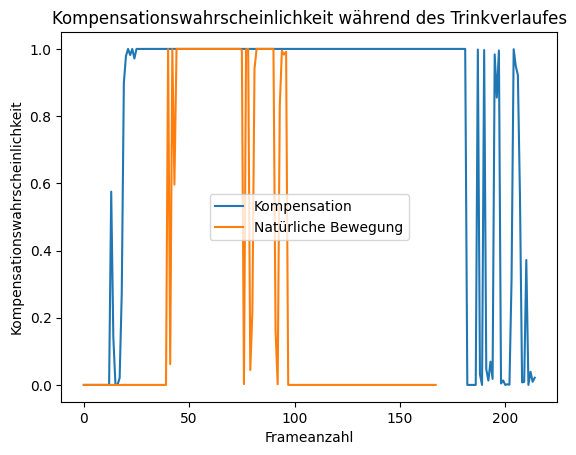

In [198]:
'''
Darstellung der Kompensationswahrscheinlichkeit während der Trinkbewegung
'''
plt.plot(predict_video(video_index=225, window_size=10), label="Kompensation")
plt.plot(predict_video(video_index=523, window_size=10), label="Natürliche Bewegung")
plt.legend()
plt.title(label="Kompensationswahrscheinlichkeit während des Trinkverlaufes")
plt.xlabel('Frameanzahl')
plt.ylabel('Kompensationswahrscheinlichkeit')

# 7. Darstellung des Trinkverlaufs

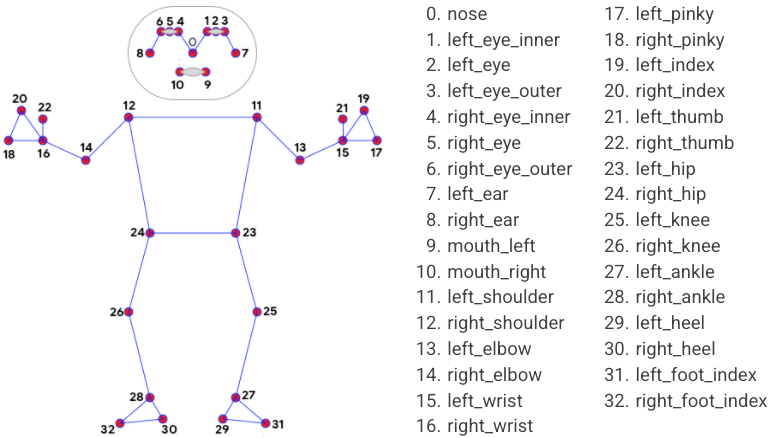
Quelle: https://google.github.io/mediapipe/solutions/pose.html

In [199]:
centered_videos = center_data(remap_raw_videos(videos_raw))
landmarks = list(data.columns)[3:]
video_keys = list(dict(videos_raw).keys())

# Plot der Trinkbewegung
def plot_landmark(video_index=525, landmark="y_0", plotlabel="Bewegung", title="Trinkbewegung"):
    landmark_movement = np.array(centered_videos[video_index])[:,landmarks.index(landmark)]
    plt.plot(landmark_movement, label=plotlabel)
    plt.legend()
    plt.title(label=title)
    plt.xlabel('Frameanzahl')
    plt.ylabel('Höhe des Landmarks')

In [200]:
# Hier kann durch ausprobieren ein Key gesucht werden
print("Video 1: " + videos_raw[523][0])
print("Video 2: " + videos_raw[223][0])

video_natural = video_keys.index('data/video/normal\drinking_normal00001.mp4')
video_compensation = video_keys.index('data/video/compensation\drinking_compensation00001.mp4')

Video 1: data/video/normal\drinking_normal00001.mp4
Video 2: data/video/compensation\drinking_compensation00001.mp4


## 7.1 Beispiele von Trinkbewegungen

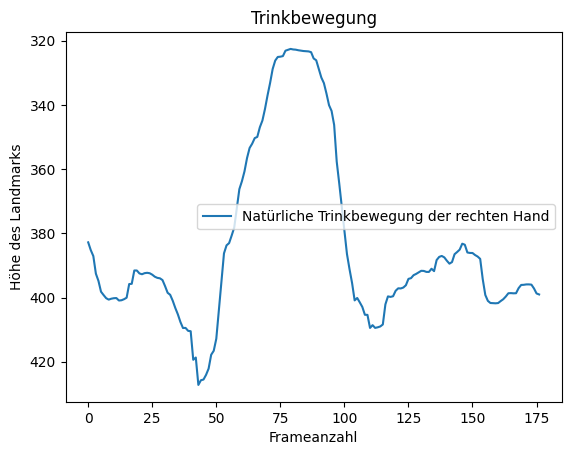

In [201]:
plot_landmark(video_index=video_natural, landmark="y_14", plotlabel="Natürliche Trinkbewegung der rechten Hand")
plt.gca().invert_yaxis() # Die Y-Achse wird invertiert, da tiefere Koordinatenwerte höhrere Positionen bedeuten.

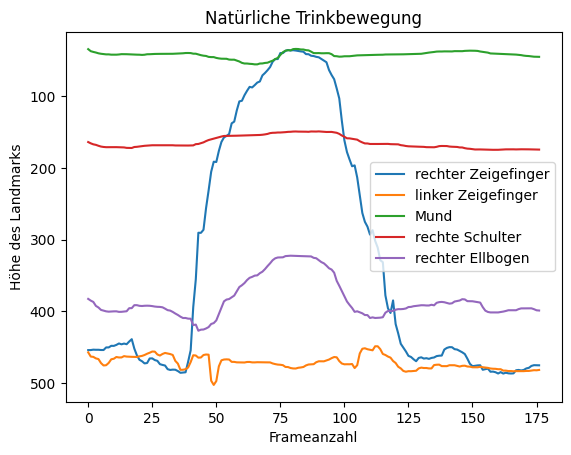

In [202]:
plot_landmark(video_index=video_natural, landmark="y_20", plotlabel="rechter Zeigefinger")
plot_landmark(video_index=video_natural, landmark="y_19", plotlabel="linker Zeigefinger")
plot_landmark(video_index=video_natural, landmark="y_10", plotlabel="Mund")
plot_landmark(video_index=video_natural, landmark="y_12", plotlabel="rechte Schulter")
plot_landmark(video_index=video_natural, landmark="y_14", plotlabel="rechter Ellbogen", title='Natürliche Trinkbewegung')
plt.gca().invert_yaxis() # Die Y-Achse wird invertiert, da tiefere Koordinatenwerte höhrere Positionen bedeuten.

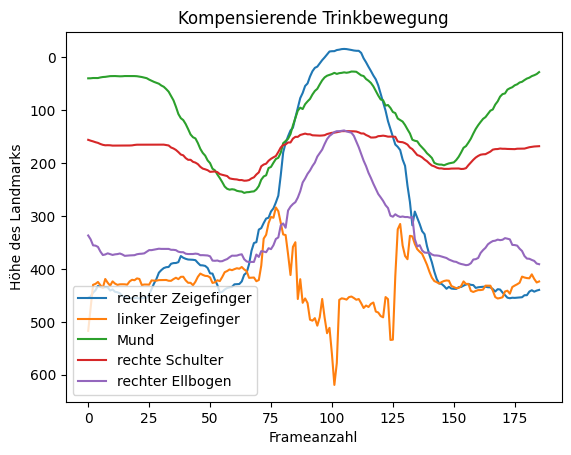

In [203]:
plot_landmark(video_index=video_compensation, landmark="y_20", plotlabel="rechter Zeigefinger")
plot_landmark(video_index=video_compensation, landmark="y_19", plotlabel="linker Zeigefinger")
plot_landmark(video_index=video_compensation, landmark="y_10", plotlabel="Mund")
plot_landmark(video_index=video_compensation, landmark="y_12", plotlabel="rechte Schulter")
plot_landmark(video_index=video_compensation, landmark="y_14", plotlabel="rechter Ellbogen", title='Kompensierende Trinkbewegung')
plt.gca().invert_yaxis() # Die Y-Achse wird invertiert, da tiefere Koordinatenwerte höhrere Positionen bedeuten.

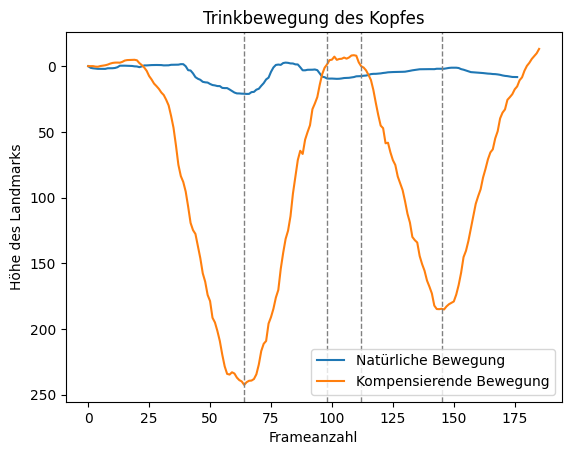

In [204]:
plot_landmark(video_index=video_natural, landmark="y_0", plotlabel="Natürliche Bewegung")
plot_landmark(video_index=video_compensation, landmark="y_0", plotlabel="Kompensierende Bewegung", title='Trinkbewegung des Kopfes')
plt.gca().invert_yaxis() # Die Y-Achse wird invertiert, da tiefere Koordinatenwerte höhrere Positionen bedeuten.

# Vertikale Linien, welche die Übergänge der Phasen der kompensierenden Bewegungen anzeigen
plt.axvline(64, lw=1, ls='--', c='grey')
plt.axvline(98, lw=1, ls='--', c='grey')
plt.axvline(112, lw=1, ls='--', c='grey')
plt.axvline(145, lw=1, ls='--', c='grey')

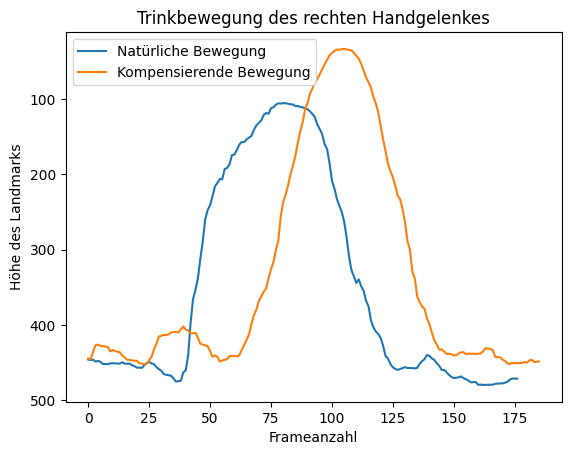

In [205]:
plot_landmark(video_index=video_natural, landmark="y_16", plotlabel="Natürliche Bewegung")
plot_landmark(video_index=video_compensation, landmark="y_16", plotlabel="Kompensierende Bewegung", title='Trinkbewegung des rechten Handgelenkes')
plt.gca().invert_yaxis() # Die Y-Achse wird invertiert, da tiefere Koordinatenwerte höhrere Positionen bedeuten.

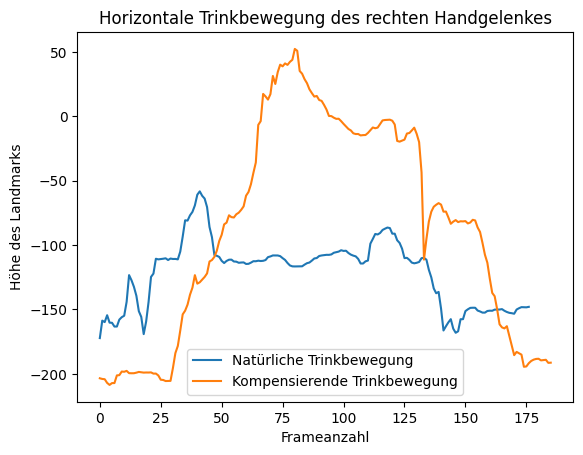

In [206]:
plot_landmark(video_index=video_natural, landmark="x_16", plotlabel="Natürliche Trinkbewegung")
plot_landmark(video_index=video_compensation, landmark="x_16", plotlabel="Kompensierende Trinkbewegung", title="Horizontale Trinkbewegung des rechten Handgelenkes")

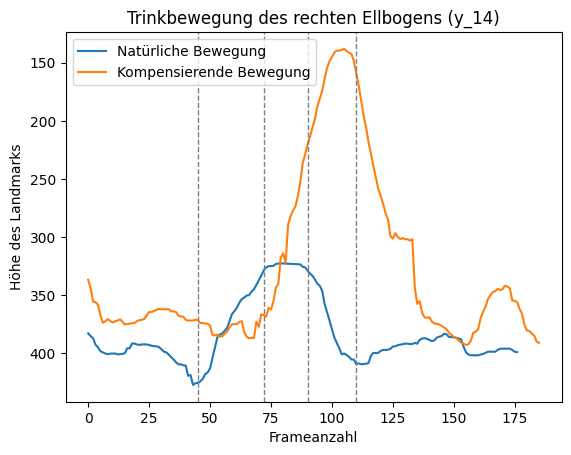

In [207]:
plot_landmark(video_index=video_natural, landmark="y_14", plotlabel="Natürliche Bewegung")
plot_landmark(video_index=video_compensation, landmark="y_14", plotlabel="Kompensierende Bewegung", title="Trinkbewegung des rechten Ellbogens (y_14)")
plt.gca().invert_yaxis() # Die Y-Achse wird invertiert, da tiefere Koordinatenwerte höhrere Positionen bedeuten.

# Vertikale Linien, welche die Übergänge der Phasen der natürlichen Bewegungen anzeigen
plt.axvline(45, lw=1, ls='--', c='grey')
plt.axvline(72, lw=1, ls='--', c='grey')
plt.axvline(90, lw=1, ls='--', c='grey')
plt.axvline(110, lw=1, ls='--', c='grey')

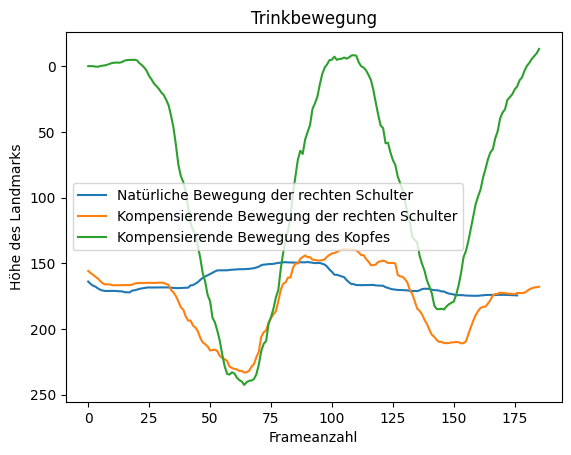

In [208]:
plot_landmark(video_index=video_natural, landmark="y_12", plotlabel="Natürliche Bewegung der rechten Schulter")
plot_landmark(video_index=video_compensation, landmark="y_12", plotlabel="Kompensierende Bewegung der rechten Schulter")
plot_landmark(video_index=video_compensation, landmark="y_0", plotlabel="Kompensierende Bewegung des Kopfes")
plt.gca().invert_yaxis() # Die Y-Achse wird invertiert, da tiefere Koordinatenwerte höhrere Positionen bedeuten.

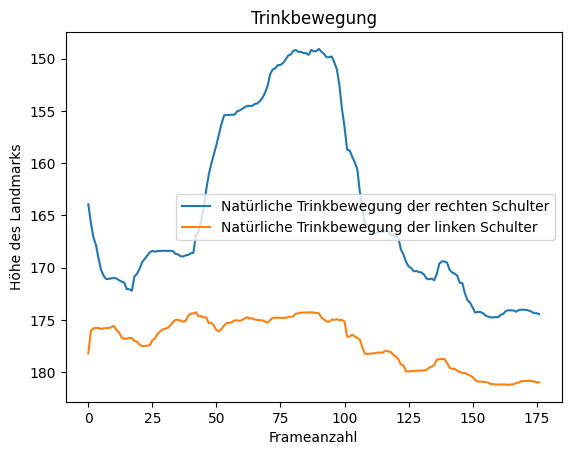

In [209]:
plot_landmark(video_index=video_natural, landmark="y_12", plotlabel="Natürliche Trinkbewegung der rechten Schulter")
plot_landmark(video_index=video_natural, landmark="y_11", plotlabel="Natürliche Trinkbewegung der linken Schulter")
plt.gca().invert_yaxis() # Die Y-Achse wird invertiert, da tiefere Koordinatenwerte höhrere Positionen bedeuten.